In [1]:
import pylab
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.tools.visualization import plot_histogram
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library.phase_oracle import PhaseOracle
import os
import tempfile
from qiskit.exceptions import MissingOptionalLibraryError
import networkx as nx
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
graph = { "a" : ["b", "c"],
          "b" : ["c", "a"],
          "c" : ["a", "b"],
        }

graph_converter = {}
for i, j in zip(graph, range(len(graph))):
    graph_converter[i] = str(j + 1)

graph_convert = {}
for i in graph:
    graph_convert[graph_converter[i]] = [graph_converter[j] for j in graph[i]]

graph_convert

{'1': ['2', '3'], '2': ['3', '1'], '3': ['1', '2']}

In [3]:
# not (S1C1 and S3C1) = not S1C1 or not S3C1
cnf_1 = []
for i in graph_convert:
    for j in graph_convert[i]:
        for c in range(3):
            cnf_1.append('-S' + str(i) + 'C' + str(c+1) + ' -S' + str(j) + 'C' + str(c+1) + ' 0')
cnf_1[0]

'-S1C1 -S2C1 0'

In [4]:
print(cnf_1)

['-S1C1 -S2C1 0', '-S1C2 -S2C2 0', '-S1C3 -S2C3 0', '-S1C1 -S3C1 0', '-S1C2 -S3C2 0', '-S1C3 -S3C3 0', '-S2C1 -S3C1 0', '-S2C2 -S3C2 0', '-S2C3 -S3C3 0', '-S2C1 -S1C1 0', '-S2C2 -S1C2 0', '-S2C3 -S1C3 0', '-S3C1 -S1C1 0', '-S3C2 -S1C2 0', '-S3C3 -S1C3 0', '-S3C1 -S2C1 0', '-S3C2 -S2C2 0', '-S3C3 -S2C3 0']


In [5]:
# S1C1 xor S1C2 xor S1C3 = (not S1C1 or not S1C2 or S1C3) and (not S1C1 or S1C2 or not S1C3) and (S1C1 or not S1C2 or not S1C3) and (S1C1 or S1C2 or S1C3)
cnf_2 = []
for i in graph_convert:
    cnf_2.append('-S' + str(i) + 'C1 -S' + str(i) + 'C2 S' + str(i) + 'C3' + ' 0')
    cnf_2.append('-S' + str(i) + 'C1 S' + str(i) + 'C2 -S' + str(i) + 'C3' + ' 0')
    cnf_2.append('S' + str(i) + 'C1 -S' + str(i) + 'C2 -S' + str(i) + 'C3' + ' 0')
    cnf_2.append('S' + str(i) + 'C1 S' + str(i) + 'C2 S' + str(i) + 'C3' + ' 0')
cnf_2[0]

'-S1C1 -S1C2 S1C3 0'

In [6]:
lenght = len(cnf_1) + len(cnf_2)
cnf_1 = '\n'.join(cnf_1)
cnf_2 = '\n'.join(cnf_2)
cnf = cnf_1 + '\n' + cnf_2
lenght

30

In [7]:
all_ = []

for i in graph_convert:
    for j in range(3):
        all_.append('S'+ str(i) + 'C' + str(j+1))

converter = {}
for i, j in zip(all_, range(len(all_))):
    converter[i] = str(j + 1)

In [8]:
for i in converter:
    cnf = cnf.replace(i, converter[i])

In [9]:
input_sat_instance = '''
c example DIMACS-CNF SAT
p cnf '''

input_sat_instance += str(len(converter)) + ' ' + str(lenght) + '\n' + cnf
print(input_sat_instance)


c example DIMACS-CNF SAT
p cnf 9 30
-1 -4 0
-2 -5 0
-3 -6 0
-1 -7 0
-2 -8 0
-3 -9 0
-4 -7 0
-5 -8 0
-6 -9 0
-4 -1 0
-5 -2 0
-6 -3 0
-7 -1 0
-8 -2 0
-9 -3 0
-7 -4 0
-8 -5 0
-9 -6 0
-1 -2 3 0
-1 2 -3 0
1 -2 -3 0
1 2 3 0
-4 -5 6 0
-4 5 -6 0
4 -5 -6 0
4 5 6 0
-7 -8 9 0
-7 8 -9 0
7 -8 -9 0
7 8 9 0


In [10]:
fp = tempfile.NamedTemporaryFile(mode='w+t', delete=False)
fp.write(input_sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except MissingOptionalLibraryError as ex:
    print(ex)
finally:
    os.remove(file_name)

In [11]:
problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

In [12]:
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=4096)
grover = Grover(quantum_instance=quantum_instance)
result = None
if problem is not None:
    result = grover.amplify(problem)
    print(result.assignment)

010100001


['green', 'red', 'blue']


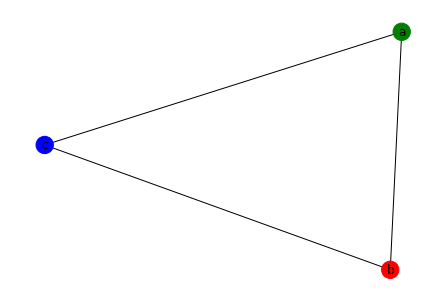

In [13]:
G = nx.Graph(graph)
pos = nx.spring_layout(G)

sortie = [str(result.assignment)[i*3: i*3+3] for i in range(int(len(str(result.assignment))/3))]

color = ['red', 'green', 'blue']
color_map = [None for i in graph]
for i, j in zip(sortie, range(len(sortie))):
    if i == '100':
        color_map[j] = color[0]
    if i == '010':
        color_map[j] = color[1]
    if i == '001':
        color_map[j] = color[2]

print(color_map)

nx.draw(G, pos, node_color=color_map, with_labels=True)
plt.show()